# Video Face Manipulation Detection Through Ensemble of CNNs
Image and Sound Processing Lab - Politecnico di Milano
- Nicolò Bonettini
- Edoardo Daniele Cannas
- Sara Mandelli
- Luca Bondi
- Paolo Bestagini


In [1]:
!git clone https://github.com/polimi-ispl/icpr2020dfdc
%pip install efficientnet-pytorch
%pip install -U git+https://github.com/albu/albumentations > /dev/null
%cd icpr2020dfdc/notebook

fatal: destination path 'icpr2020dfdc' already exists and is not an empty directory.
Note: you may need to restart the kernel to use updated packages.
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /private/var/folders/16/xfx_gvv952jdprrpdvgfy79h0000gn/T/pip-req-build-foff7_0p
Note: you may need to restart the kernel to use updated packages.
/Users/hiteshgupta/Documents/SIH24/ML_Models/icpr2020dfdc/notebook


/Users/hiteshgupta/Documents/SIH24/ML_Models/DF/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import torch
from torch.utils.model_zoo import load_url
import matplotlib.pyplot as plt
from scipy.special import expit

import sys
sys.path.append('..')

from blazeface import FaceExtractor, BlazeFace, VideoReader
from architectures import fornet,weights
from isplutils import utils

## Parameters

In [3]:
"""
Choose an architecture between
- EfficientNetB4
- EfficientNetB4ST
- EfficientNetAutoAttB4
- EfficientNetAutoAttB4ST
- Xception
"""
net_model = 'EfficientNetAutoAttB4'

"""
Choose a training dataset between
- DFDC
- FFPP
"""
train_db = 'DFDC'

In [4]:
device = torch.device('mps')
face_policy = 'scale'
face_size = 224
frames_per_video = 32

## Initialization

In [5]:
model_url = weights.weight_url['{:s}_{:s}'.format(net_model,train_db)]
net = getattr(fornet,net_model)().eval().to(device)
net.load_state_dict(load_url(model_url,map_location=device,check_hash=True))

Loaded pretrained weights for efficientnet-b4


<All keys matched successfully>

In [6]:
transf = utils.get_transformer(face_policy, face_size, net.get_normalizer(), train=False)

In [7]:
facedet = BlazeFace().to(device)
facedet.load_weights("../blazeface/blazeface.pth")
facedet.load_anchors("../blazeface/anchors.npy")
videoreader = VideoReader(verbose=False)
video_read_fn = lambda x: videoreader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn=video_read_fn,facedet=facedet)

/Users/hiteshgupta/Documents/SIH24/ML_Models/icpr2020dfdc/notebook/../blazeface/blazeface.py:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.lo

## Detect faces

In [8]:
vid_real_faces = face_extractor.process_video('/content/00032.mp4')
vid_fake_faces = face_extractor.process_video('/content/id0_id2_0005.mp4')

In [9]:
im_real_face = vid_real_faces[0]['faces'][0]
im_fake_face = vid_fake_faces[0]['faces'][0]

IndexError: list index out of range

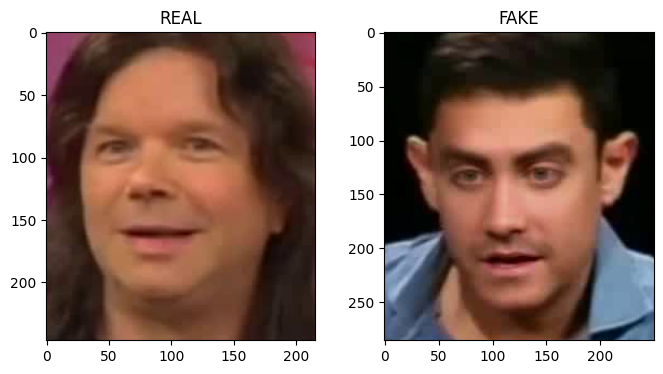

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(im_real_face)
ax[0].set_title('REAL')

ax[1].imshow(im_fake_face)
ax[1].set_title('FAKE');

## Predict scores for each frame

In [18]:
test_video = '/Users/hiteshgupta/Documents/SIH24/ML_Models/a8d8e9f8-783e-4078-a5e7-dc9063033031.MP4'
vid_face_extractor = face_extractor.process_video(test_video)

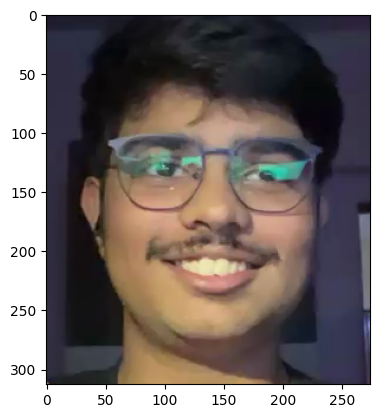

In [19]:
im_faces = vid_face_extractor[0]['faces'][0]
# show the image
plt.imshow(im_faces)

In [20]:
# For each frame, we consider the face with the highest confidence score found by BlazeFace (= frame['faces'][0])
im_face = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_face_extractor if len(frame['faces'])] )
with torch.no_grad():
    faces_pred = net(im_face.to(device)).cpu().numpy().flatten()

In [21]:
print('Average score for video: {:.4f}'.format(expit(faces_pred.mean())))

Average score for video: 0.1605


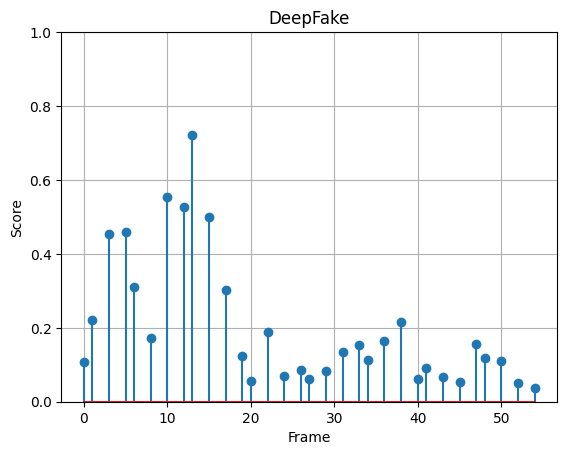

In [22]:
# plot each frame
plt.stem([f['frame_idx'] for f in vid_face_extractor if len(f['faces'])],expit(faces_pred))
plt.title('DeepFake')
plt.xlabel('Frame')
plt.ylabel('Score')
plt.ylim([0,1])
plt.grid(True)